In [1]:
#importing the required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.metrics import classification_report
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler

pd.set_option('display.max_columns', None)

In [2]:
data1 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Podcast_listening_time_prediction/train.csv')
data2 = pd.read_csv('C:/Data_Science/Personal_Notebooks/Podcast_listening_time_prediction/test.csv')

train = data1.copy()
test = data2.copy()

train.head()

,id,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.41998
1,1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031


In [3]:
train.isnull().sum(), test.isnull().sum()

(id                                  0
 Podcast_Name                        0
 Episode_Title                       0
 Episode_Length_minutes          87093
 Genre                               0
 Host_Popularity_percentage          0
 Publication_Day                     0
 Publication_Time                    0
 Guest_Popularity_percentage    146030
 Number_of_Ads                       1
 Episode_Sentiment                   0
 Listening_Time_minutes              0
 dtype: int64,
 id                                 0
 Podcast_Name                       0
 Episode_Title                      0
 Episode_Length_minutes         28736
 Genre                              0
 Host_Popularity_percentage         0
 Publication_Day                    0
 Publication_Time                   0
 Guest_Popularity_percentage    48832
 Number_of_Ads                      0
 Episode_Sentiment                  0
 dtype: int64)

In [4]:
train = train.fillna(train.median(numeric_only= True))
test = test.fillna(test.median(numeric_only= True))

In [5]:
num = train.select_dtypes(include='number')
cat = test.select_dtypes(exclude='number')

num.columns, cat.columns

(Index(['id', 'Episode_Length_minutes', 'Host_Popularity_percentage',
        'Guest_Popularity_percentage', 'Number_of_Ads',
        'Listening_Time_minutes'],
       dtype='object'),
 Index(['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day',
        'Publication_Time', 'Episode_Sentiment'],
       dtype='object'))

In [6]:
#lower case columns

def lower_case(data, cols= None):
    if cols == None:
        cols = data.columns
    data.rename(columns={col : col.lower() for col in cols}, inplace= True)

In [7]:
lower_case(num, ['id', 'Episode_Length_minutes', 'Host_Popularity_percentage',
        'Guest_Popularity_percentage', 'Number_of_Ads',
        'Listening_Time_minutes'])

lower_case(cat, ['Podcast_Name', 'Episode_Title', 'Genre', 'Publication_Day',
        'Publication_Time', 'Episode_Sentiment'])

In [8]:
num = num.drop(columns='id')

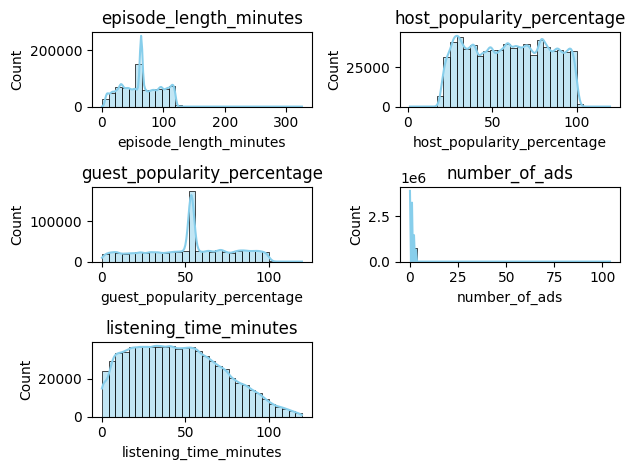

In [9]:
num1 = num.copy()

for i, column in enumerate(num1, 1):
    plt.subplot(3, 2, i)
    sns.histplot(num[column], kde=True, bins=30, color='skyblue', linewidth=0.5)
    plt.title(f'{column}')
    plt.tight_layout()

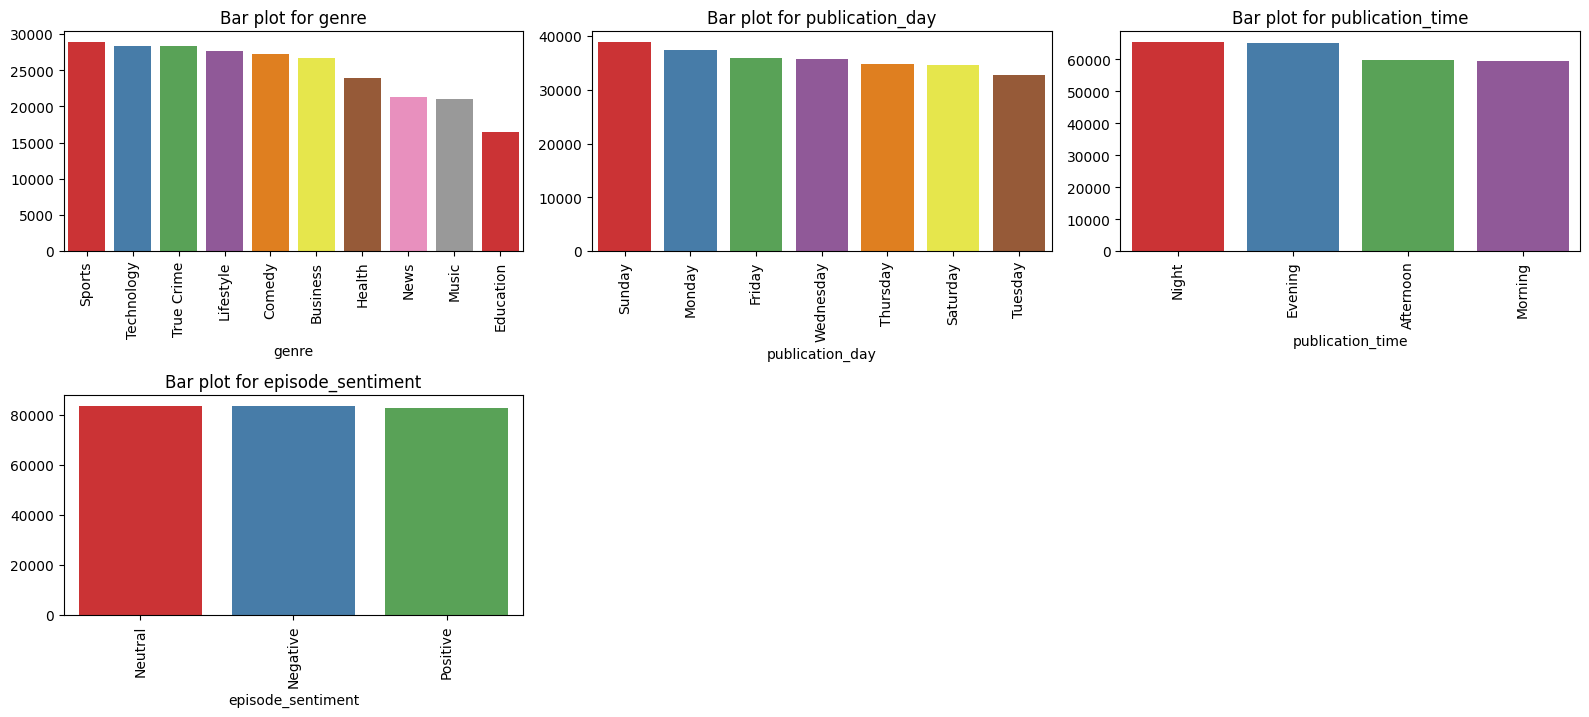

In [10]:
cat1 = cat.copy()

cat1 = cat1.drop(columns=['podcast_name', 'episode_title'])

plt.figure(figsize=(16, 10))
for i, column in enumerate(cat1, 1):
    plt.subplot(3, 3, i)
    sns.barplot(x=cat1[column].value_counts().index, y=cat1[column].value_counts().values, palette='Set1')
    plt.xticks(rotation=90)
    plt.title(f'Bar plot for {column}')
    plt.tight_layout()


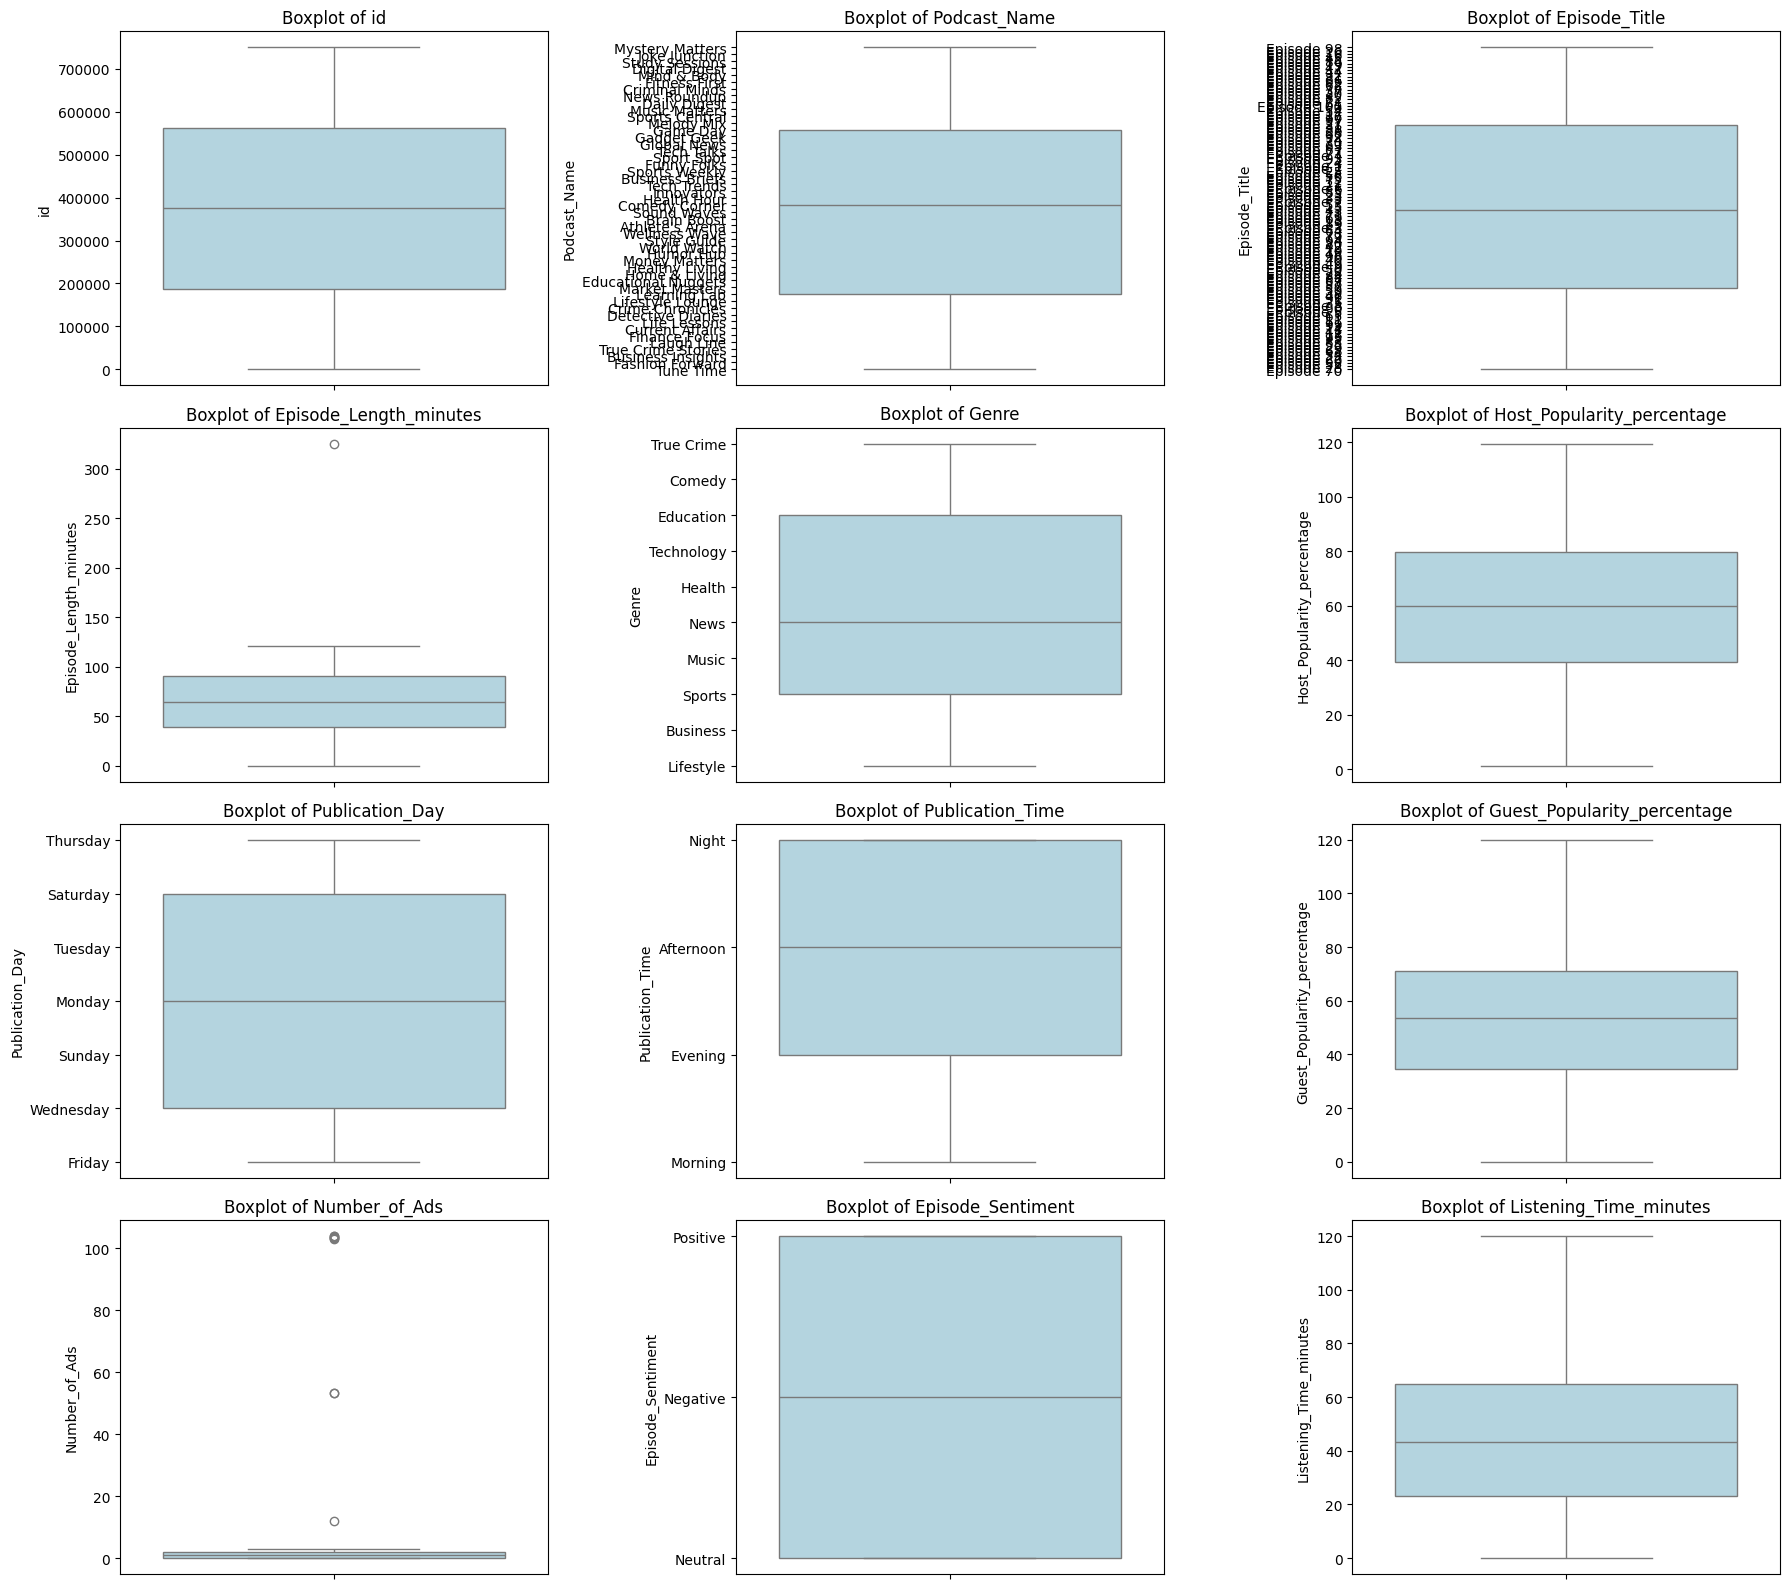

In [17]:
cols = train.columns
n_cols = 3 
n_rows = (len(cols) + n_cols - 1) // n_cols

plt.figure(figsize=(6 * n_cols, 4 * n_rows))

for i, column in enumerate(cols, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=train[column], color='lightblue')
    plt.title(f'Boxplot of {column}')
    plt.tight_layout()

plt.show()

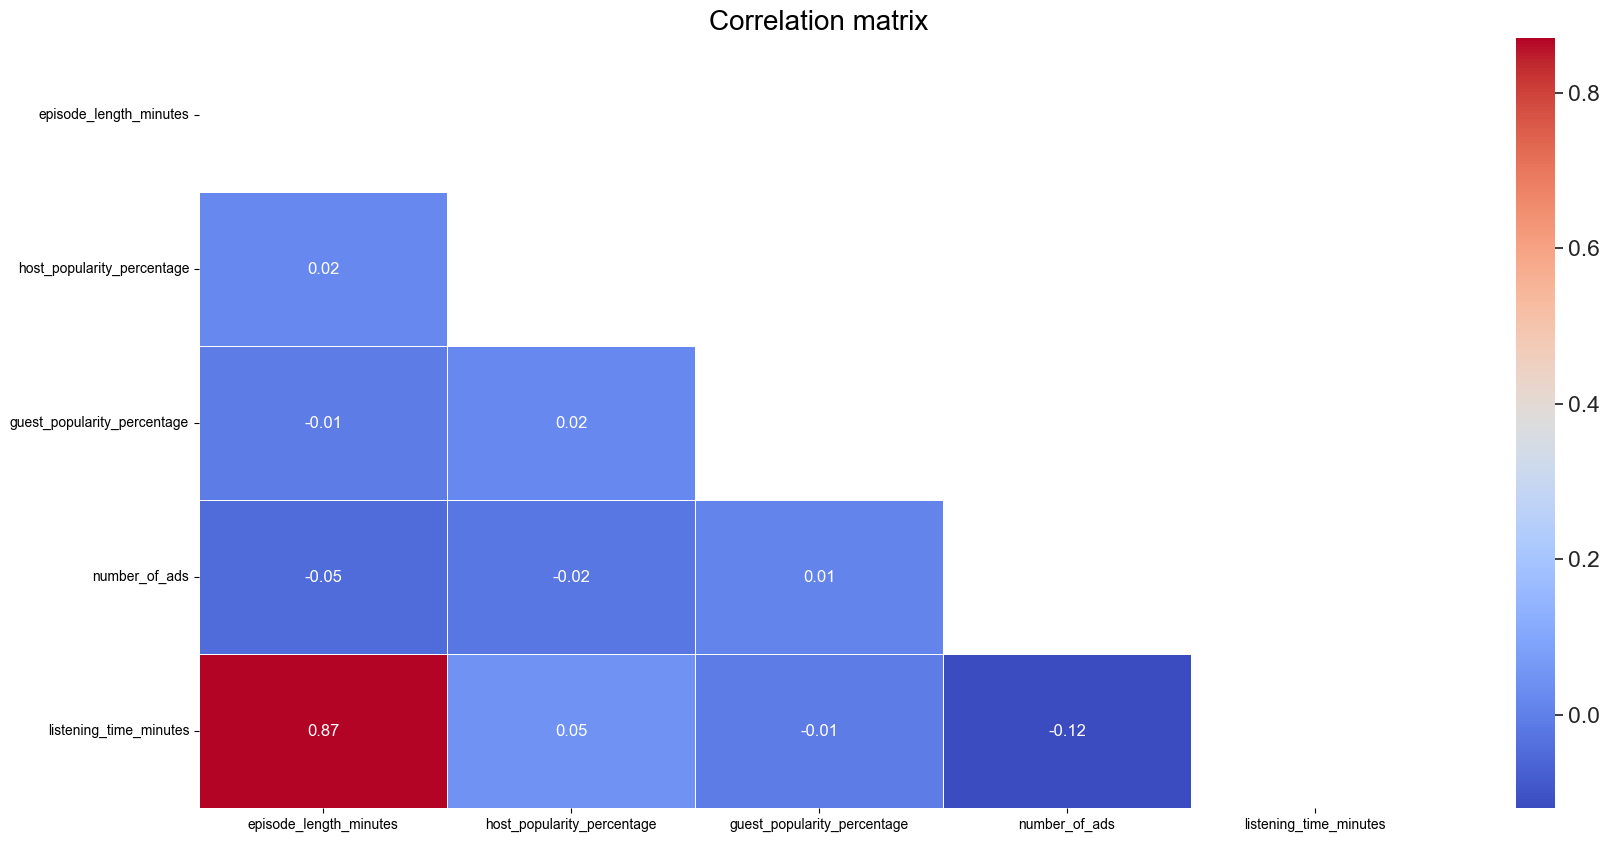

In [19]:
num_corr = round(num.corr(), 2)

# Correlation Matrix-Heatmap Plot
mask = np.zeros_like(num_corr)
mask[np.triu_indices_from(mask)] = True # optional, to hide repeat half of the matrix

f, ax = plt.subplots(figsize=(20, 10))
sns.set_theme(font_scale=1.5) # increase font size

ax = sns.heatmap(num_corr, mask=mask, annot=True, annot_kws={"size": 12}, linewidths=.5, cmap="coolwarm", fmt=".2f", ax=ax) # round to 2 decimal places
ax.set_title("Correlation matrix", fontsize=20) # add title
plt.show()
